### Thesis ADS: Rosa Lucassen

# Loading the data

In [1]:
import pickle
import pandas as pd
import numpy as np
from numpy import array
import scipy

import spacy
import stop_words
nlp = spacy.load("en_core_web_sm")
nlp.vocab["covid"].is_stop = True
nlp.vocab["corona"].is_stop = True
nlp.vocab["covid19"].is_stop = True
nlp.vocab["covid-19"].is_stop = True
nlp.vocab["coronavirus"].is_stop = True
nlp.vocab["k"].is_stop = True

import re
import emoji
from collections import Counter
from scipy.stats import chi2_contingency
from urllib.parse import urlparse
from nltk.stem.porter import PorterStemmer

import gensim
from gensim.models import Phrases
from gensim.corpora import Dictionary
from gensim.models.wrappers import LdaMallet
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary

import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import logging
import json

import warnings
warnings.filterwarnings('ignore')  # To ignore all warnings that arise here to enhance clarity
stemmer = PorterStemmer()

import matplotlib.pyplot as plt
import nltk
from nltk import FreqDist
import liwc

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/rosalucassen/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Function: Cleaning data

In [8]:
def remove_single_char(text):
    single_char_pattern = r'\s+[a-zA-Z]\s+'
    without_sc = re.sub(pattern=single_char_pattern, repl=" ", string=text)
    return without_sc

def remove_numbers(text):
    number_pattern = r'\b(?<![0-9-])(\d+)(?![0-9-])'
    without_number = re.sub(pattern=number_pattern, repl=" ", string=text)
    return without_number


def remove_urls(text):
    url_pattern = r'https?://\S+|www\.\S+'
    without_urls = re.sub(pattern=url_pattern, repl=" ", string=text)
    return without_urls


def remove_emojis(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    without_emoji = emoji_pattern.sub(r'',text)
    return without_emoji

def remove_nonalpha(text):
    nonalpha_pattern = "[+$@#?~]"
    without_nonalpha = re.sub(pattern=nonalpha_pattern, repl=" ", string=text)
    return without_nonalpha
    
def remove_rt(text):
    rt_pattern = 'rt @[\w_]+: '
    without_pattern = re.sub(pattern = rt_pattern, repl=" ", string = text)
    return without_pattern 

def remove_extra_spaces(text):
    space_pattern = r'\s+'
    without_space = re.sub(pattern=space_pattern, repl=" ", string=text)
    return without_space

def strip_list_noempty(mylist):
    newlist = (item.strip() if hasattr(item, 'strip') else item for item in mylist)
    return [item for item in newlist if item != '']

# Function: BiGrams

In [9]:
from gensim.models import Phrases
def make_n_grams(docs):
    # Add bigrams and trigrams to docs (only ones that appear 20 times or more).
    bigram = Phrases(docs, min_count=1)
    for idx in range(len(docs)):
        for token in bigram[docs[idx]]:
            if '_' in token:
                # Token is a bigram, add to document.
                docs[idx].append(token)
    return docs

# Function: Lemmatizing texts

In [10]:
def pre_processer(corpus):
    corpus = [text.lower() for text in corpus]
    corpus = [remove_urls(text) for text in corpus]
    corpus = [remove_single_char(text) for text in corpus]
    corpus = [remove_numbers(text) for text in corpus]
    corpus = [remove_rt(text) for text in corpus]
    corpus = [remove_emojis(text) for text in corpus]
    corpus = [remove_nonalpha(text) for text in corpus]
    corpus = [text.encode("ascii", "ignore") for text in corpus]
    corpus = [text.decode() for text in corpus]
    corpus = [remove_extra_spaces(text) for text in corpus]
    corpus = strip_list_noempty(corpus)

    processed_texts = [text for text in nlp.pipe(corpus, 
                                              disable=["ner",
                                                       "parser"])]
    tokenized_texts = [[word.lemma_ for word in lemma_ if not word.is_punct if not word.is_stop] 
                            for lemma_ in processed_texts]
    tokenized_texts = make_n_grams(tokenized_texts)
    
    flatten = lambda t: [item for sublist in t for item in sublist]
    flat = flatten(tokenized_texts)
    counts = Counter(flat)
    total_words = sum(counts.values()) 
    for word in counts:
        counts[word] = counts[word]
    return counts, counts.most_common(), flat, tokenized_texts

# Function: Topic modelling LDA Gensim

In [7]:
# Shows all words instead of just the 10 most popular words
def topic_modelling_results(tokenized_text, n_topics, n_iterations):
    results = []

    dictionary = Dictionary(tokenized_text) # get the vocabulary
    corpus = [dictionary.doc2bow(text) for text in tokenized_text]

    PATH_TO_MALLET = '/Users/rosalucassen/Documents/UU/DataMining/mallet-2.0.8/bin/mallet'
    N_TOPICS = n_topics
    N_ITERATIONS = n_iterations

    lda = LdaMallet(PATH_TO_MALLET,
                    corpus=corpus,
                    id2word=dictionary,
                    num_topics=N_TOPICS,
                    iterations=N_ITERATIONS,
                    alpha = 0.2)
    
    for topic in range(N_TOPICS):
        words = lda.show_topic(topic)
        topic_n_words = ' '.join([word[0] for word in words])
        result = {'Topic':str(topic), 
                    'Words':topic_n_words}
        results.append(result)
    results_DF = pd.DataFrame(results)
    pd.set_option('display.max_colwidth', None)
    return results_DF, lda, dictionary

# Function: Compute Coherence Scores

In [9]:
def compute_coherence_values(texts, start, step, limit, topn):
    dictionary = Dictionary(texts) # get the vocabulary
    dictionary.filter_extremes(no_below=5, no_above=0.5)
    corpus = [dictionary.doc2bow(text) for text in texts]
    
    # Put your own PATH_TO_MALLET here
    PATH_TO_MALLET = '/Users/rosalucassen/Documents/UU/DataMining/mallet-2.0.8/bin/mallet'
    
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(PATH_TO_MALLET, corpus=corpus, num_topics=num_topics, id2word=dictionary, alpha = 0.2, iterations = 400)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v', topn=topn)
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

## Exploring the data

In [10]:
d_test = pd.read_excel("/Users/rosalucassen/Desktop/Thesis/Code/Data/Constraint_English_Test2.xlsx", engine='openpyxl')
d_train = pd.read_excel("/Users/rosalucassen/Desktop/Thesis/Code/Data/Constraint_English_Train.xlsx", engine='openpyxl')
d_val = pd.read_excel("/Users/rosalucassen/Desktop/Thesis/Code/Data/Constraint_English_Val.xlsx", engine='openpyxl')
d_test_labeled = pd.read_excel("/Users/rosalucassen/Desktop/Thesis/Code/Data/english_test_with_labels.xlsx", engine='openpyxl')

#### Training data

In [ ]:
d_train.info()

In [ ]:
d_train.head()

In [ ]:
d_train["label"].unique()

In [ ]:
grouped_train = d_train.groupby('label').count() 
grouped_train.head()

#### Validation data

In [ ]:
d_val.info()

In [ ]:
d_val.head()

In [ ]:
d_val["label"].unique()

In [ ]:
grouped_val = d_val.groupby('label').count() 
grouped_val.head()

#### Test data

In [ ]:
d_test.info()

In [ ]:
d_test.head()

In [ ]:
d_test_labeled.info()

In [ ]:
d_test_labeled.head()

In [ ]:
d_test_labeled["label"].unique()

In [ ]:
grouped_test = d_test_labeled.groupby('label').count() 
grouped_test.head()

#### Combine data

In [11]:
data_train = d_train.append([d_val, d_test_labeled], ignore_index=True)
data_train.tail()

,id,tweet,label
10695,2136,#CoronaVirusUpdates: State-wise details of Tot...,real
10696,2137,Tonight 12(midnight) onwards Disaster Manageme...,fake
10697,2138,296 new cases of #COVID19Nigeria; Plateau-85 E...,real
10698,2139,RT @CDCemergency: #DYK? @CDCgov’s One-Stop Sho...,real
10699,2140,More than half of pregnant women recently admi...,real


In [ ]:
data_train.info()

In [ ]:
grouped_train = data_train.groupby('label').count() 
grouped_train.head()

## Results: Pre-processing

In [15]:
# Overall pre-processing
word_count, output, flat, tokenized_texts = pre_processer(data_train["tweet"])
print(output[:20])

# Fake data pre-processing
corpus_train_fake = data_train[data_train.label == "fake"]["tweet"]
word_count_fake, output_fake, flat_fake, tokenized_texts_fake = pre_processer(corpus_train_fake)
print(output_fake[:20])

# Real data pre-processing
corpus_train_real = data_train[data_train.label == "real"]["tweet"]
word_count_real, output_real, flat_real, tokenized_texts_real = pre_processer(corpus_train_real)
print(output_real[:20])

[('case', 3331), ('test', 2162), ('new', 1829), ('report', 1615), ('state', 1580), ('death', 1333), ('people', 1290), ('number', 1162), ('total', 909), ('day', 906), ('india', 828), ('confirm', 819), ('say', 803), ('amp', 795), ('today', 701), ('testing', 686), ('health', 672), ('vaccine', 636), ('hospital', 635), ('update', 605)]
[('say', 575), ('claim', 521), ('people', 507), ('virus', 441), ('vaccine', 405), ('trump', 390), ('pandemic', 368), ('case', 368), ('new', 366), ('test', 351), ('video', 327), ('india', 327), ('hospital', 319), ('death', 289), ('president', 277), ('show', 276), ('die', 271), ('cure', 266), ('lockdown', 250), ('patient', 238)]
[('case', 2963), ('test', 1810), ('report', 1481), ('new', 1463), ('state', 1371), ('number', 1057), ('death', 1044), ('total', 878), ('people', 783), ('confirm', 731), ('amp', 705), ('day', 693), ('today', 641), ('testing', 606), ('update', 577), ('indiafightscorona', 546), ('india', 501), ('health', 477), ('high', 459), ('active', 393

### Most common words

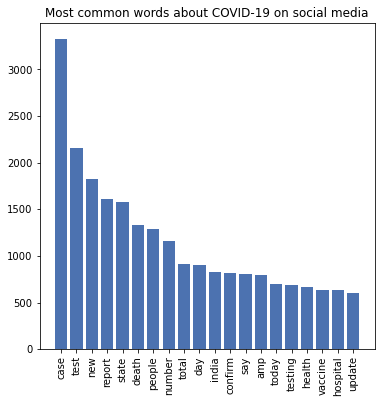

In [16]:
dictionary = dict(output[:20])
keys = dictionary.keys()
values = dictionary.values()

plt.style.use('seaborn-deep')
plt.bar(list(keys), values, alpha = 1)
plt.xticks(list(keys), color='black', rotation=90)
plt.yticks(color='black')
plt.title("Most common words about COVID-19 on social media")
plt.gcf().set_size_inches(6, 6)
plt.savefig("common.pdf",bbox_inches='tight')
plt.show()

#plt.bar(keys, values)

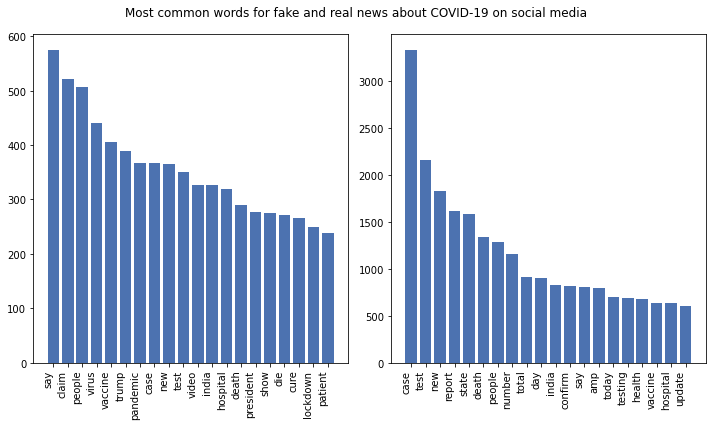

In [17]:
dictionary_fake = dict(output_fake[:20])
keys_fake = dictionary_fake.keys()
values_fake = dictionary_fake.values()

dictionary_real = dict(output_real[:20])
keys_real = dictionary.keys()
values_real = dictionary.values()

plt.style.use('seaborn-deep')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,6))
ax1.bar(list(keys_fake), values_fake, alpha = 1)
ax2.bar(list(keys_real), values_real, alpha = 1)
fig.suptitle('Most common words for fake and real news about COVID-19 on social media')
fig.autofmt_xdate(rotation=90)
fig.tight_layout()
plt.savefig("common_fake_real.pdf",bbox_inches='tight')
plt.show()

### Frequency of words

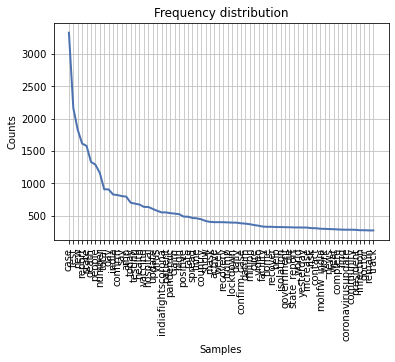

<AxesSubplot:title={'center':'Frequency distribution'}, xlabel='Samples', ylabel='Counts'>

In [19]:
fdist_filtered = FreqDist(word_count)
fdist_filtered.plot(70,title='Frequency distribution')

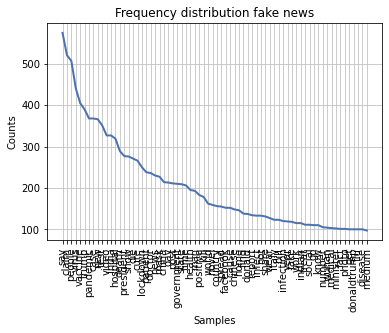

<AxesSubplot:title={'center':'Frequency distribution fake news'}, xlabel='Samples', ylabel='Counts'>

In [20]:
fdist_filtered = FreqDist(word_count_fake)
fdist_filtered.plot(70,title='Frequency distribution fake news')

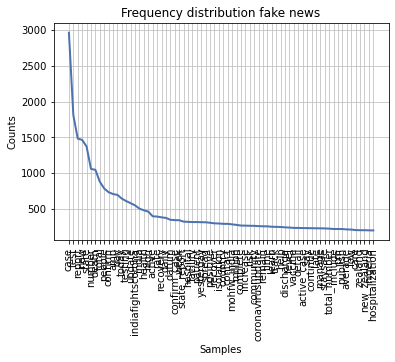

<AxesSubplot:title={'center':'Frequency distribution fake news'}, xlabel='Samples', ylabel='Counts'>

In [21]:
fdist_filtered = FreqDist(word_count_real)
fdist_filtered.plot(70,title='Frequency distribution fake news')

# Results: Optimal number of topics

In [ ]:
# Calculate coherence score 
all_scores = []
for n in range(5, 15, 5):
    model_list, coherence_values = compute_coherence_values(texts=tokenized_texts, start=1, step=1, limit= 40, topn=n)
    all_scores.append(coherence_values)
all_scores = np.array(all_scores)
avg_scores = np.average(all_scores, axis=0)
print(avg_scores)

In [ ]:
# Plot the coherence score
limit=40; start=1; step=1;
x = range(start, limit, step)
plt.plot(x, avg_scores)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.show()

## Results: Topic modelling LDA Gensim

In [ ]:
topics, lda_model, dictionary = topic_modelling_results(tokenized_texts, 21, n_iterations = 1000)

In [ ]:
# Write results to a CSV file 
topics.to_csv('Topics_top_words.csv', index=False)

## Document topic distribution

###### Loop over documents to get topic distribution

In [ ]:
transformed_docs = lda_model.load_document_topics()

In [ ]:
for i, document in enumerate(transformed_docs):
    print('Topic distributions for document {}'.format(i))
    for topic in document:
        print(topic)

In [ ]:
transformed_docs = lda_model.load_document_topics()
topic_distributions = pd.DataFrame([[x[1] for x in doc] for doc in transformed_docs],
                                  columns=['topic_{}'.format(i) for i in range(21)])
data = pd.concat([data_train, topic_distributions], axis = 1) 
data.drop(data.columns[0], axis=1, inplace = True)
data.to_csv('data_topic_dist.csv', index=False)

# Proportions per Topic 

In [2]:
data = pd.read_csv("data_topic_dist.csv")

data_fake = data[data.label == "fake"]
data_fake['Max'] = data_fake.iloc[:, 2:23].idxmax(axis=1)
data_grouped_fake = data_fake.groupby("Max").count()
data_grouped_fake = data_grouped_fake.iloc[:, [0]]

data_real = data[data.label =="real"]
data_real['Max'] = data_real.iloc[:, 2:23].idxmax(axis=1)
data_grouped_real = data_real.groupby("Max").count()
data_grouped_real = data_grouped_real.iloc[:, [0]]

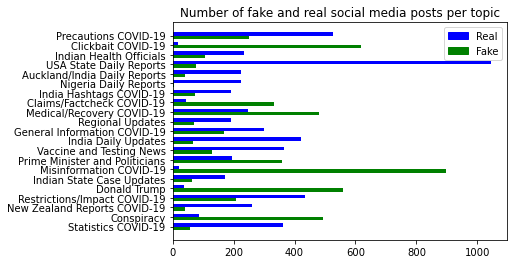

In [3]:
height1 = data_grouped_real["tweet"]
height2 = data_grouped_fake["tweet"]

bars = ("Statistics COVID-19", "Conspiracy", "New Zealand Reports COVID-19", "Restrictions/Impact COVID-19",
        "Donald Trump", "Indian State Case Updates", "Misinformation COVID-19",
        "Prime Minister and Politicians", "Vaccine and Testing News", "India Daily Updates", "General Information COVID-19",
        "Regional Updates", "Medical/Recovery COVID-19", "Claims/Factcheck COVID-19",
        "India Hashtags COVID-19", "Nigeria Daily Reports", "Auckland/India Daily Reports",
        "USA State Daily Reports", "Indian Health Officials", "Clickbait COVID-19", "Precautions COVID-19")

x_pos = np.arange(len(bars))

# Create bars
plt.style.use('seaborn-deep')
plt.barh(x_pos, height1, alpha = 1, color = "blue", height=0.35, align = 'edge')
plt.barh(x_pos, height2, alpha = 1, color = 'green', height=-0.35, align = 'edge')

# Create names on the x-axis
plt.yticks(x_pos, bars, color='black')#,  rotation=90)
plt.xticks(color='black')

colors = {'Real':'blue', 'Fake':'green'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)
plt.title("Number of fake and real social media posts per topic")

# Show graphic
plt.savefig("proportionplot.pdf",bbox_inches='tight')
plt.show()

# Sentiment Analysis

In [45]:
data = pd.read_csv("data_topic_dist.csv")

# Results: VADER

In [46]:
sid = SentimentIntensityAnalyzer()

In [47]:
def compound_func(compound):
    if compound < -0.05:
        return "neg"
    elif compound > 0.05:
        return "pos"
    else:
        return 'neu'

def VADER(df):
    df['scores'] = df['tweet'].apply(lambda tweet: sid.polarity_scores(tweet))
    df['compound']  = df['scores'].apply(lambda score_dict: score_dict['compound'])
    df['Class'] = df['compound'].apply(compound_func)
    return df

In [48]:
data_VADER = VADER(data)
data_VADER['Max'] = data_VADER.iloc[:, 2:23].idxmax(axis=1)
data_VADER.update(data_VADER.iloc[:, 2:23].mul(data_VADER.compound, 0))   

In [51]:
topic_list = ["topic_0", "topic_1", "topic_2", "topic_3", "topic_4", "topic_5", "topic_6", "topic_7",
             "topic_8", "topic_9", "topic_10", "topic_11", "topic_12", "topic_13", "topic_14",
            "topic_15", "topic_16", "topic_17", "topic_18", "topic_19", "topic_20"]

for topic in topic_list:
    data = data_VADER[data_VADER.Max == topic]    
    n = len(data)
    av_c = sum(data["compound"])/n
    print("Average compound score of {} for topic {}".format(av_c, topic))

Average compound score of 0.033410213776722084 for topic topic_0
Average compound score of -0.056256357388316136 for topic topic_1
Average compound score of -0.06229037138927091 for topic topic_2
Average compound score of 0.2627304511278192 for topic topic_3
Average compound score of -0.035800000000000005 for topic topic_4
Average compound score of 0.09662883895131093 for topic topic_5
Average compound score of 0.038499732858414897 for topic topic_6
Average compound score of -0.046745294117647024 for topic topic_7
Average compound score of -0.023753605015673977 for topic topic_8
Average compound score of 0.10039201030927832 for topic topic_9
Average compound score of 0.07008372093023259 for topic topic_10
Average compound score of 0.015021339563862932 for topic topic_11
Average compound score of -0.11750185185185187 for topic topic_12
Average compound score of 0.047855274261603395 for topic topic_13
Average compound score of -0.1550085059978189 for topic topic_14
Average compound score

# Check assumptions for t-test

## Normality

In [52]:
from scipy import stats
def normality_test(data, topic):
    dt = data[data.Max == topic]
    fake = dt[dt.label == "fake"]
    real = dt[dt.label == "real"]
    
    n_fake = len(fake)
    n_real = len(real)
    
    k2_fake, p_fake = stats.normaltest(array(fake["compound"]))
    alpha = 0.05
    #print("p = {:g}".format(p))
    if p_fake < alpha:  # null hypothesis: x comes from a normal distribution
        print("The null hypothesis can be rejected for the fake data {} with p-value {}".format(topic, p))
    else:
        print("The null hypothesis cannot be rejected for the fake data {}".format(topic))
        
    k2_real, p_real = stats.normaltest(array(real["compound"]))
    alpha = 0.1
    #print("p = {:g}".format(p))
    if p_real < alpha:  # null hypothesis: x comes from a normal distribution
        print("The null hypothesis can be rejected for the real data of {}".format(topic))
    else:
        print("The null hypothesis cannot be rejected for the real data of {}".format(topic))

In [53]:
topic_list = ["topic_0", "topic_1", "topic_2", "topic_3", "topic_4", "topic_5", "topic_6", "topic_7",
        "topic_8", "topic_9", "topic_10", "topic_11", "topic_12", "topic_13", "topic_14",
        "topic_15", "topic_16", "topic_17", "topic_18", "topic_19", "topic_20"]
    
for elem in topic_list:
    try:
        normality_test(data_VADER, str(elem))
    except:
        print("Too little data to compute normality for topic {}".format(elem))
        pass 
    print(" ")

The null hypothesis cannot be rejected for the fake data topic_0
The null hypothesis can be rejected for the real data of topic_0
 
The null hypothesis cannot be rejected for the fake data topic_1
The null hypothesis cannot be rejected for the real data of topic_1
 
Too little data to compute normality for topic topic_2
 
The null hypothesis cannot be rejected for the fake data topic_3
The null hypothesis can be rejected for the real data of topic_3
 
Too little data to compute normality for topic topic_4
 
The null hypothesis cannot be rejected for the fake data topic_5
The null hypothesis can be rejected for the real data of topic_5
 
The null hypothesis cannot be rejected for the fake data topic_6
The null hypothesis can be rejected for the real data of topic_6
 
Too little data to compute normality for topic topic_7
 
Too little data to compute normality for topic topic_8
 
The null hypothesis cannot be rejected for the fake data topic_9
The null hypothesis can be rejected for the 

## Homoscedasticity

In [54]:
def boxplot(data, topic):
    dt = data[data.Max == topic]
    #fake = dt[dt.label == "fake"]
    #real = dt[dt.label == "real"]
    
    import seaborn as sns
    plt.style.use('seaborn-deep')
    sns.set_theme(style="whitegrid")
    ax = sns.boxplot(x=dt["label"], y = dt["compound"])
    ax.set_title("Homoscedasticity assumption check")

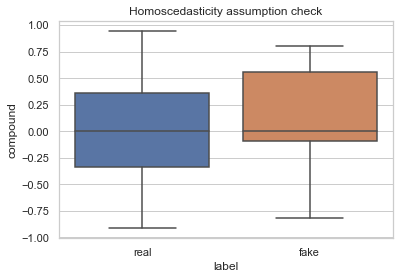

In [55]:
boxplot(data_VADER, "topic_0")

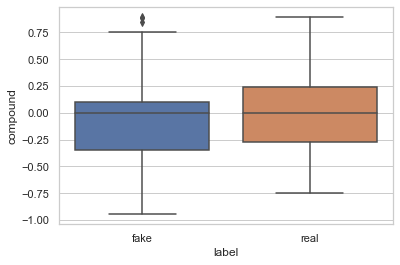

In [11]:
boxplot(data_VADER, "topic_1")

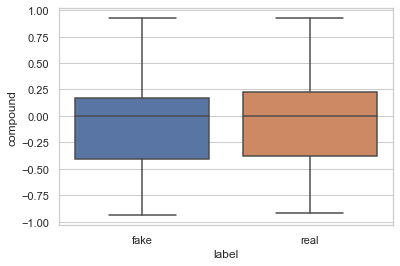

In [12]:
boxplot(data_VADER, "topic_2")

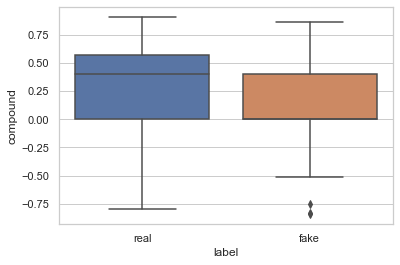

In [13]:
boxplot(data_VADER, "topic_3")

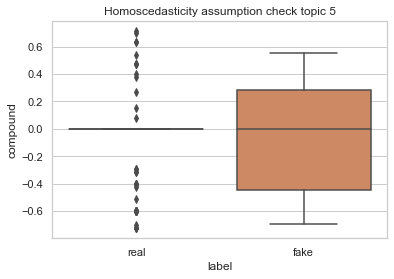

In [64]:
boxplot(data_VADER, "topic_4")

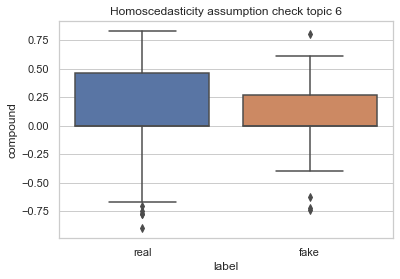

In [72]:
boxplot(data_VADER, "topic_5")

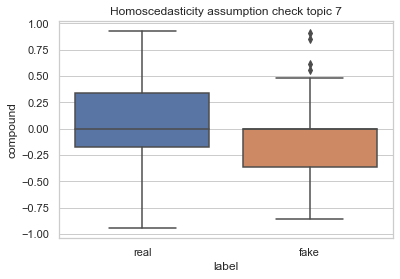

In [69]:
boxplot(data_VADER, "topic_6")

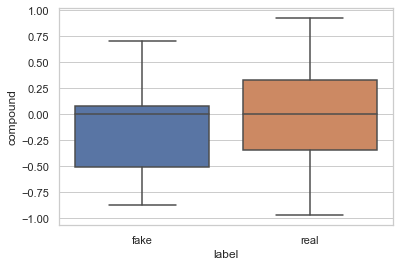

In [17]:
boxplot(data_VADER, "topic_7")

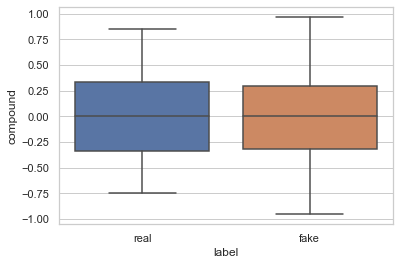

In [18]:
boxplot(data_VADER, "topic_8")

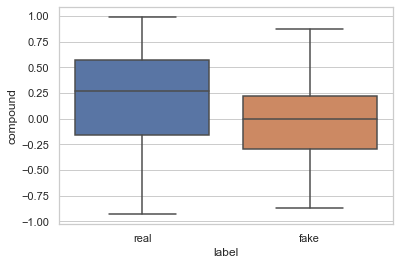

In [19]:
boxplot(data_VADER, "topic_9")

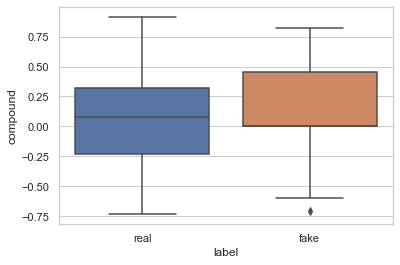

In [164]:
boxplot(data_VADER, "topic_10")

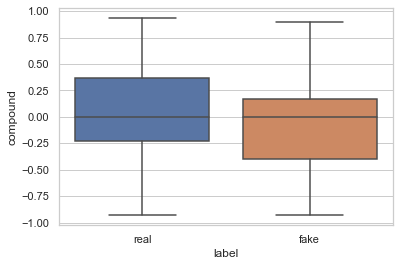

In [20]:
boxplot(data_VADER, "topic_11")

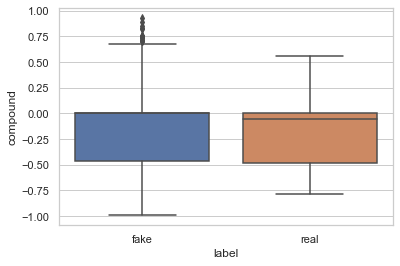

In [21]:
boxplot(data_VADER, "topic_12")

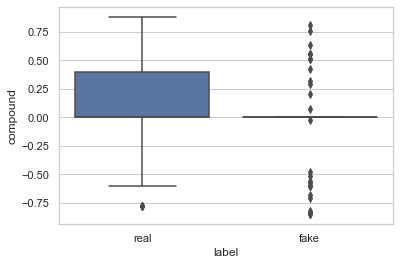

In [167]:
boxplot(data_VADER, "topic_13")

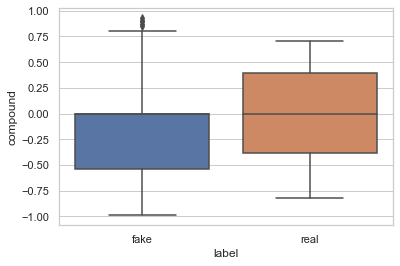

In [22]:
boxplot(data_VADER, "topic_14")

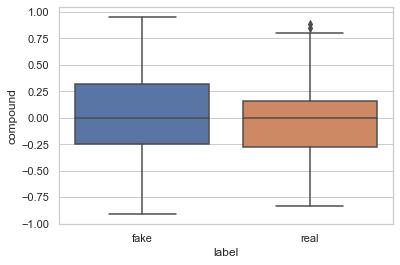

In [23]:
boxplot(data_VADER, "topic_15")

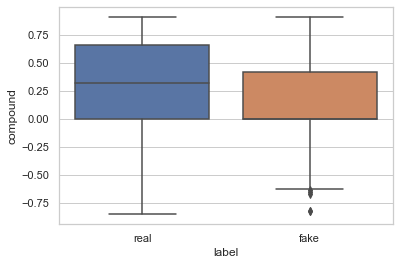

In [25]:
boxplot(data_VADER, "topic_16")

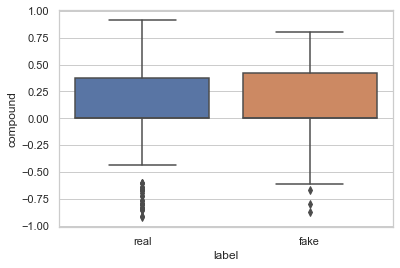

In [26]:
boxplot(data_VADER, "topic_17")

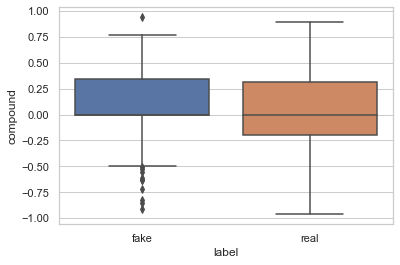

In [27]:
boxplot(data_VADER, "topic_18")

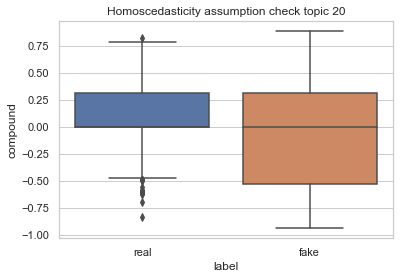

In [57]:
boxplot(data_VADER, "topic_19")

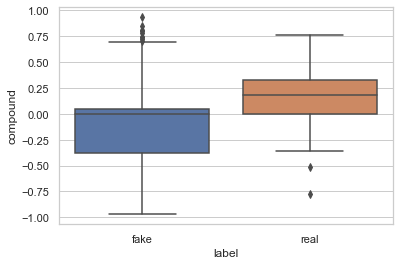

In [29]:
boxplot(data_VADER, "topic_20")

## Check assumptions Mann-Whitney Test

In [259]:
def dist_plot(data, topic):
    dt = data[data.Max == topic]
    fake = dt[dt.label == "fake"]
    real = dt[dt.label == "real"]
    
    import seaborn as sns
    sns.displot(fake["compound"])
    sns.displot(real["compound"])

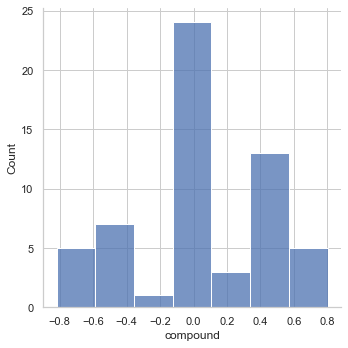

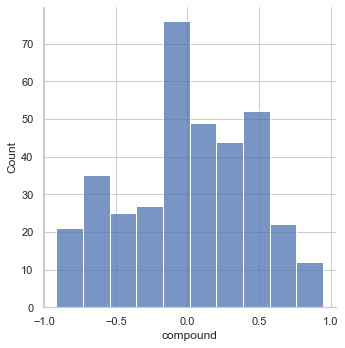

In [260]:
dist_plot(data_VADER, "topic_0")

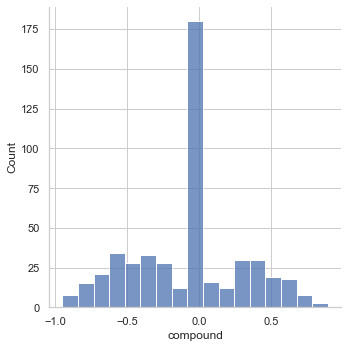

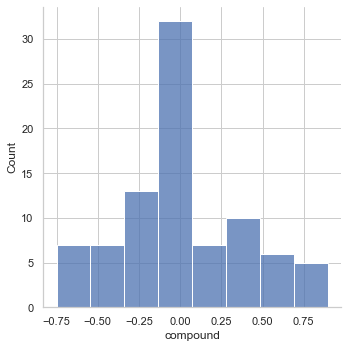

In [261]:
dist_plot(data_VADER, "topic_1")

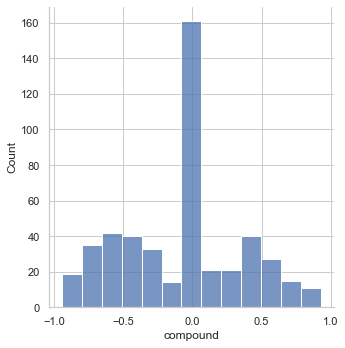

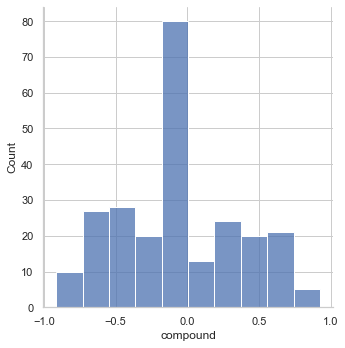

In [262]:
dist_plot(data_VADER, "topic_2")

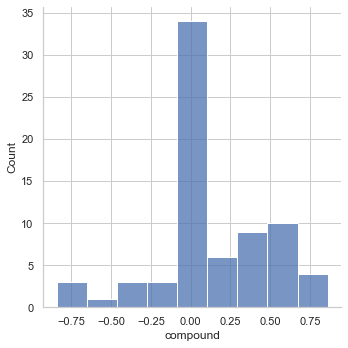

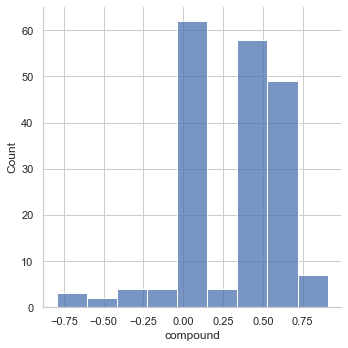

In [211]:
dist_plot(data_VADER, "topic_3")

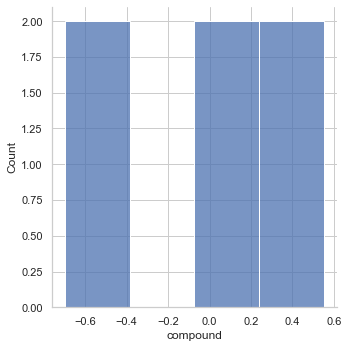

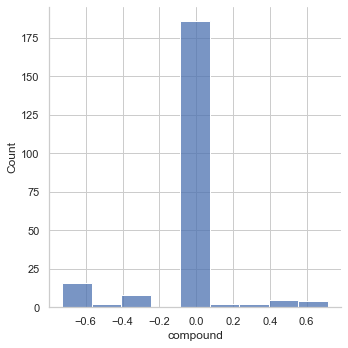

In [212]:
dist_plot(data_VADER, "topic_4")

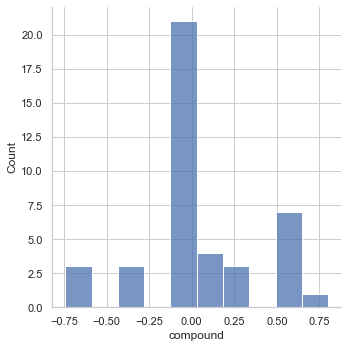

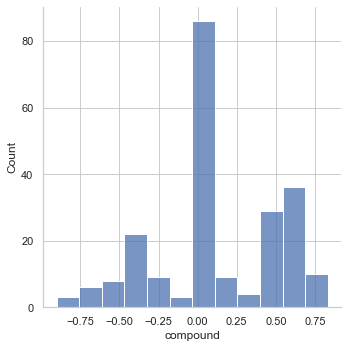

In [213]:
dist_plot(data_VADER, "topic_5")

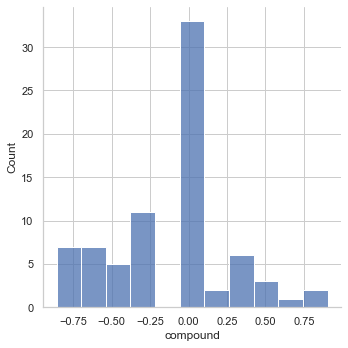

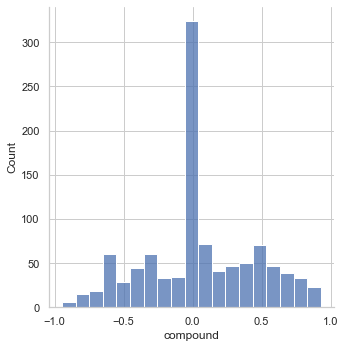

In [214]:
dist_plot(data_VADER, "topic_6")

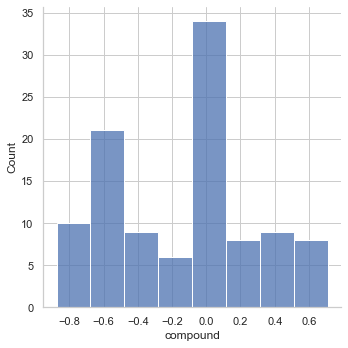

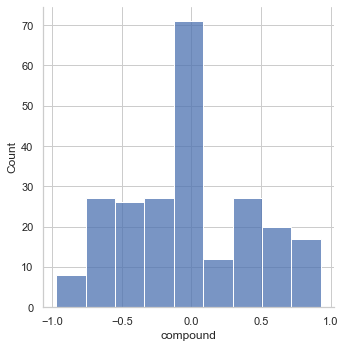

In [215]:
dist_plot(data_VADER, "topic_7")

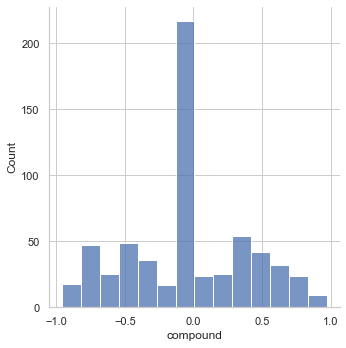

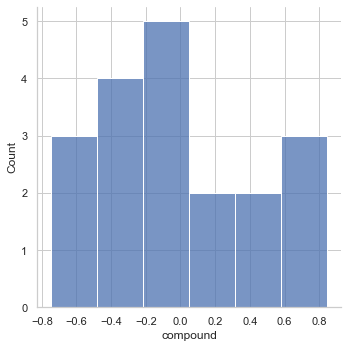

In [216]:
dist_plot(data_VADER, "topic_8")

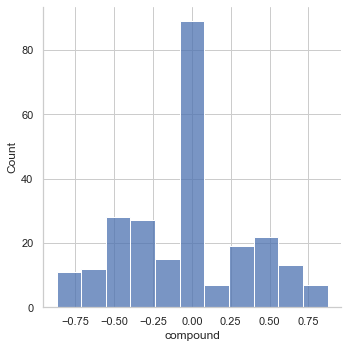

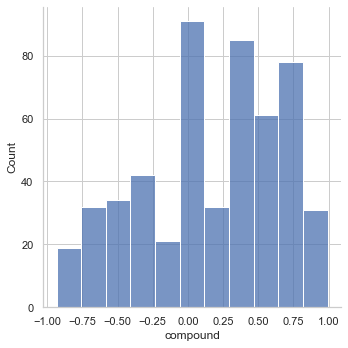

In [217]:
dist_plot(data_VADER, "topic_9")

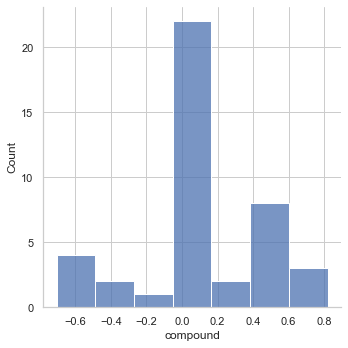

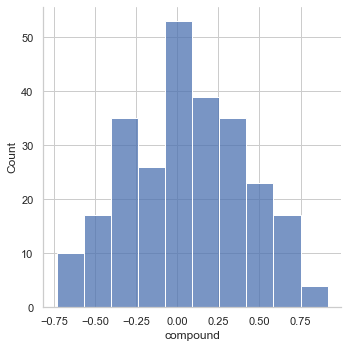

In [218]:
dist_plot(data_VADER, "topic_10")

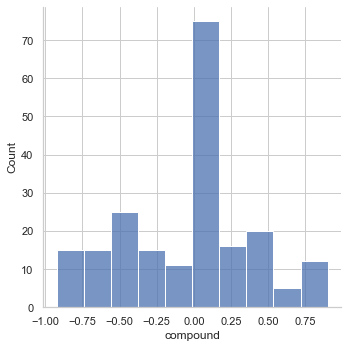

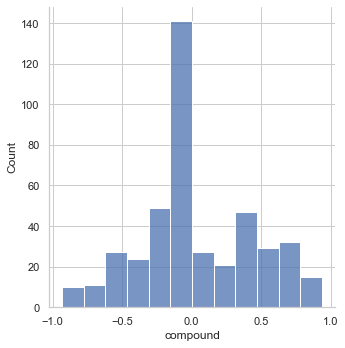

In [219]:
dist_plot(data_VADER, "topic_11")

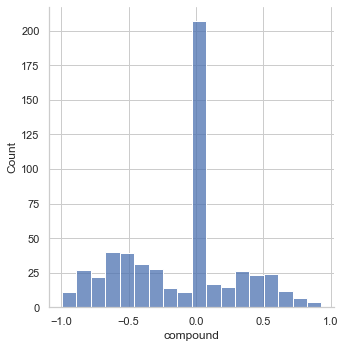

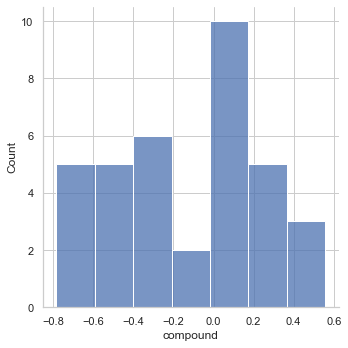

In [220]:
dist_plot(data_VADER, "topic_12")

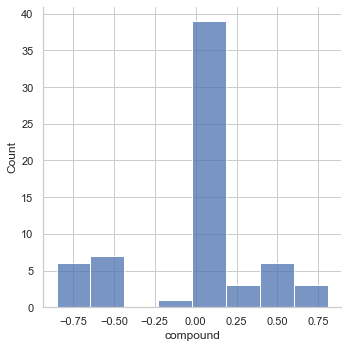

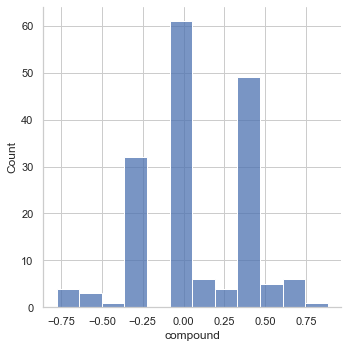

In [221]:
dist_plot(data_VADER, "topic_13")

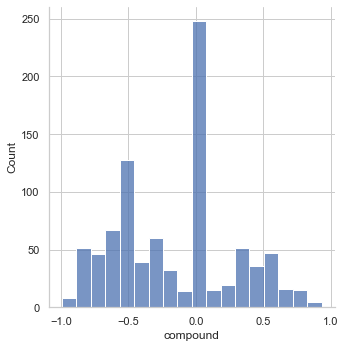

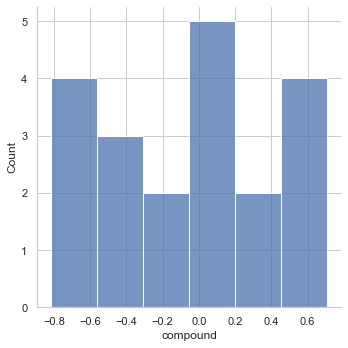

In [222]:
dist_plot(data_VADER, "topic_14")

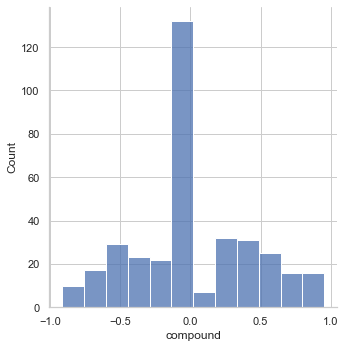

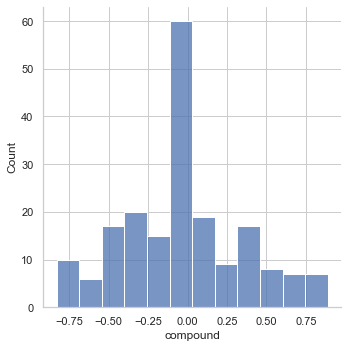

In [223]:
dist_plot(data_VADER, "topic_15")

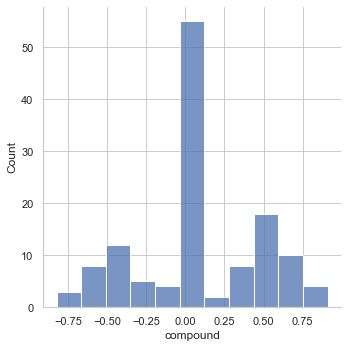

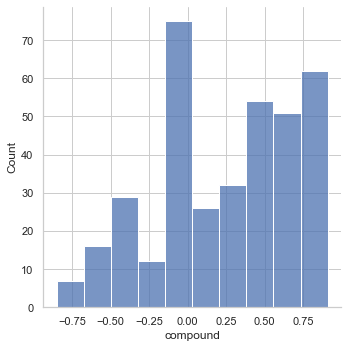

In [224]:
dist_plot(data_VADER, "topic_16")

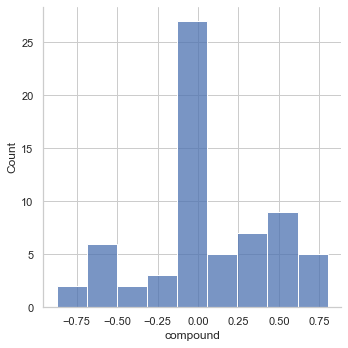

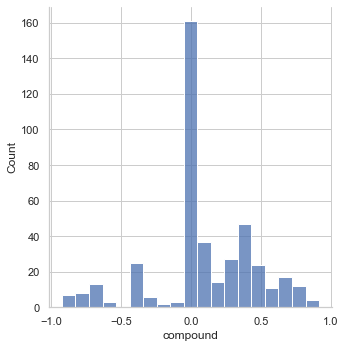

In [225]:
dist_plot(data_VADER, "topic_17")

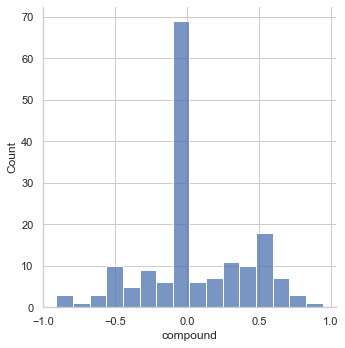

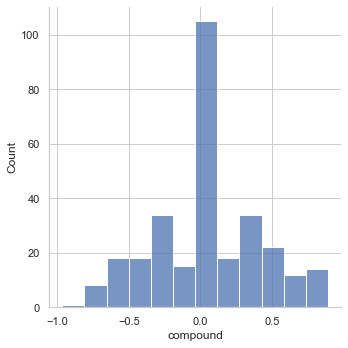

In [226]:
dist_plot(data_VADER, "topic_18")

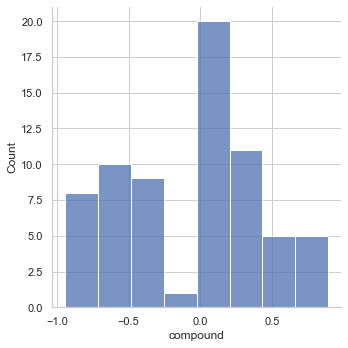

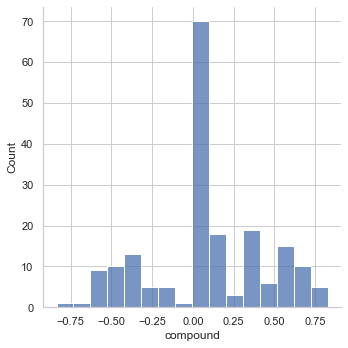

In [227]:
dist_plot(data_VADER, "topic_19")

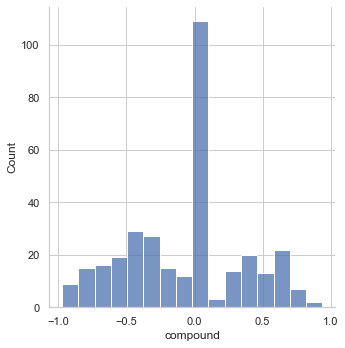

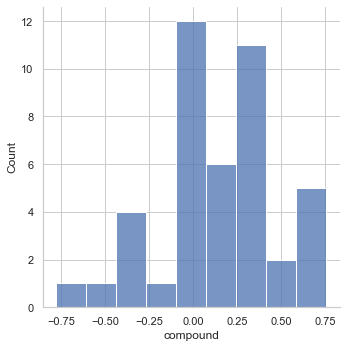

In [228]:
dist_plot(data_VADER, "topic_20")

# Results: VADER Mann-Whitney Test

In [57]:
def mannwhitney_test(data, topic):
    dt = data[data.Max == topic]
    fake = dt[dt.label == "fake"]
    real = dt[dt.label == "real"]
    
    n_fake = len(fake)
    n_real = len(real)
    print(n_fake)
    print(n_real)
    
    if n_fake > 20 and n_real > 20:
        stat_fake, p = scipy.stats.mannwhitneyu(array(fake["compound"]), array(real["compound"]), alternative = 'less')
        alpha = 0.05
        if p < alpha:  
            print("The null hypothesis can be rejected for {} with p-value {}".format(topic, p))
        else:
            print("The null hypothesis cannot be rejected for {} with p-value {}".format(topic, p))
    else:
        print("Number of data points is too little to compute Mann Whitney test")

In [58]:
def average(data, topic):
    dt = data[data.Max == topic]
    fake = dt[dt.label == "fake"]
    real = dt[dt.label == "real"]
    
    n_fake = len(fake)
    n_real = len(real)
    av_real = sum(real["compound"])/n_real
    av_fake = sum(fake["compound"])/n_fake
    print("Topic {} diff {}".format(topic, av_real-av_fake))
    

In [59]:
VADER_FAKE = data_VADER[data_VADER.label == "fake"]
VADER_REAL = data_VADER[data_VADER.label == "real"]
scipy.stats.mannwhitneyu(array(VADER_FAKE["compound"]), array(VADER_REAL["compound"]))

MannwhitneyuResult(statistic=11660430.5, pvalue=1.8483015783956607e-62)

In [61]:
topic_list = ["topic_0", "topic_1", "topic_2", "topic_3", "topic_5", "topic_6", "topic_7",
     "topic_9", "topic_10", "topic_11", "topic_12", "topic_13",
        "topic_15", "topic_16", "topic_17", "topic_18", "topic_19", "topic_20"]
    
for elem in topic_list:
    mannwhitney_test(data_VADER, str(elem))
    print(" ")

58
363
The null hypothesis cannot be rejected for topic_0 with p-value 0.6446605548406499
 
495
87
The null hypothesis cannot be rejected for topic_1 with p-value 0.13562554026365226
 
479
248
The null hypothesis cannot be rejected for topic_2 with p-value 0.12846194821288676
 
73
193
The null hypothesis can be rejected for topic_3 with p-value 0.000139712528792063
 
42
225
The null hypothesis cannot be rejected for topic_5 with p-value 0.2772671804366745
 
77
1046
The null hypothesis can be rejected for topic_6 with p-value 0.0004516675078043094
 
105
235
The null hypothesis can be rejected for topic_7 with p-value 0.020598591468786977
 
250
526
The null hypothesis can be rejected for topic_9 with p-value 5.706322020726465e-10
 
42
259
The null hypothesis cannot be rejected for topic_10 with p-value 0.5358541505457397
 
209
433
The null hypothesis can be rejected for topic_11 with p-value 0.0033480143362156823
 
558
36
The null hypothesis cannot be rejected for topic_12 with p-value 0

In [62]:
topic_list = ["topic_0", "topic_1", "topic_2", "topic_3", "topic_4", "topic_5", "topic_6", "topic_7",
        "topic_8", "topic_9", "topic_10", "topic_11", "topic_12", "topic_13", "topic_14",
        "topic_15", "topic_16", "topic_17", "topic_18", "topic_19", "topic_20"]
    
for elem in topic_list:
    average(data_VADER, str(elem))
    print(" ")

Topic topic_0 diff -0.046463322884012545
 
Topic topic_1 diff 0.07591208638105189
 
Topic topic_2 diff 0.035423515051518584
 
Topic topic_3 diff 0.17888066576761985
 
Topic topic_4 diff 0.025375777777777782
 
Topic topic_5 diff 0.034947650793650836
 
Topic topic_6 diff 0.1666175982717091
 
Topic topic_7 diff 0.11924243161094224
 
Topic topic_8 diff 0.03341720942096759
 
Topic topic_9 diff 0.20024696273764253
 
Topic topic_10 diff -0.03123127413127412
 
Topic topic_11 diff 0.10772734013282206
 
Topic topic_12 diff -0.027974103942652345
 
Topic topic_13 diff 0.11839809481216457
 
Topic topic_14 diff 0.10087869565217387
 
Topic topic_15 diff -0.05237416666666668
 
Topic topic_16 diff 0.18174678848283504
 
Topic topic_17 diff 0.011765187504498745
 
Topic topic_18 diff -0.02981968098790843
 
Topic topic_19 diff 0.15355866909477198
 
Topic topic_20 diff 0.2278621252451667
 


# Results: LIWC

In [62]:
data = pd.read_csv("data_topic_dist.csv")

In [63]:
parse, category_names = liwc.load_token_parser('liwc.dic')

In [64]:
word_count, output, flat, tokenized_texts = pre_processer(data["tweet"])

In [65]:
name_list = ['posemo', 'negemo', 'cause', 'tentat', 'certain',
             'assent', 'nonfl', 'filler', 'swear', 
             'anx', 'anger', 'sad', 'death']

data = data.assign(posemo='', negemo='', cause = '', tentat = '', certain = '',
             assent = '', nonfl = '', filler = '', swear = '', anx = '', anger = '', sad = '', death = '')

result = []
for tweet in tokenized_texts:
    c_counts = Counter(category for token in tweet for category in parse(token))
    c_counts = {k: v for k, v in c_counts.items() if k in name_list}
    result.append(dict(c_counts))
    
for i in range(len(result)):
    c_counts = result[i]
    keys = list(c_counts.keys())
    values = list(c_counts.values())
    for cat in name_list:
        if cat in keys:
            ix = keys.index(cat)
            data.at[i,cat] = values[ix]
        else:
            data.at[i,cat] = 0

# Write results of LIWC to a CSV file
data.to_csv('data_result_LIWC.csv', index=False)

In [15]:
norm_cat = data.iloc[:,23:].div(len(data.tweet), axis=0)*100
data['Max'] = data.iloc[:, 2:23].idxmax(axis=1)

In [16]:
data = pd.concat([data.iloc[:,[0,1,36]],norm_cat], axis = 1)

In [17]:
def mannwhitney_test_LIWC(data, topic, category):
    dt = data[data.Max == topic]
    fake = dt[dt.label == "fake"][category]
    real = dt[dt.label == "real"][category]
    
    n_fake = (fake > 0).sum()
    n_real = (real > 0).sum()
    
    if n_fake > 20 and n_real > 20:
        stat_fake, p = scipy.stats.mannwhitneyu(array(real), array(fake), alternative = 'less')
        alpha = 0.05
        if p < alpha: 
            print("The null hypothesis can be rejected for {} and category {} with p-value {}".format(topic, category, p))
        else:
            print("The null hypothesis cannot be rejected for {} and category {} with p-value {}".format(topic, category, p))
    else:
        print("")

In [19]:
for category in category_list:
    fake = data[data.label == "fake"][category]
    real = data[data.label == "real"][category]
    
    n_fake = (fake > 0).sum()
    n_real = (real > 0).sum()
    #print(n_fake)
    #print(n_real)
    
    if n_fake > 20 and n_real > 20:

        stat_fake, p = scipy.stats.mannwhitneyu(array(real), array(fake), alternative = 'less')
        alpha = 0.05
    #print("p = {:g}".format(p))
        if p < alpha:  # null hypothesis: x comes from a normal distribution
            print("The null hypothesis can be rejected for category {}".format(category))
        else:
            print("The null hypothesis cannot be rejected for category {}".format(category))
    else:
        print("The Mann-Whitney test cannot be computed due to small sample size for category {}".format(category))

The null hypothesis cannot be rejected for category posemo
The null hypothesis cannot be rejected for category negemo
The null hypothesis cannot be rejected for category cause
The null hypothesis cannot be rejected for category tentat
The null hypothesis cannot be rejected for category certain
The null hypothesis cannot be rejected for category assent
The null hypothesis cannot be rejected for category nonfl
The Mann-Whitney test cannot be computed due to small sample size for category filler
The Mann-Whitney test cannot be computed due to small sample size for category swear
The null hypothesis cannot be rejected for category anx
The null hypothesis can be rejected for category anger
The null hypothesis cannot be rejected for category sad
The null hypothesis cannot be rejected for category death


In [18]:
category_list = ['posemo', 'negemo', 'cause', 'tentat', 'certain',
             'assent', 'nonfl', 'filler', 'swear', 
             'anx', 'anger', 'sad', 'death']

topic_list = ["topic_0", "topic_1", "topic_2", "topic_3", "topic_4" "topic_5", "topic_6", "topic_7",
               "topic_8",  "topic_9", "topic_10", "topic_11", "topic_12", "topic_13", "topic_14",
        "topic_15", "topic_16", "topic_17", "topic_18", "topic_19", "topic_20"]
    
for topic in topic_list:
    for elem in category_list:
        mannwhitney_test_LIWC(data, str(topic), str(elem))

The null hypothesis can be rejected for topic_0 and category posemo with p-value 0.010204192343914953



The null hypothesis cannot be rejected for topic_0 and category certain with p-value 0.9123420193412013








The null hypothesis cannot be rejected for topic_1 and category posemo with p-value 0.9360443731369494
The null hypothesis cannot be rejected for topic_1 and category negemo with p-value 0.2801359905934576
The null hypothesis cannot be rejected for topic_1 and category cause with p-value 0.27426525289697956










The null hypothesis cannot be rejected for topic_2 and category posemo with p-value 0.7041139605611428
The null hypothesis cannot be rejected for topic_2 and category negemo with p-value 0.7600219332508515
The null hypothesis cannot be rejected for topic_2 and category cause with p-value 0.868401077033045
The null hypothesis cannot be rejected for topic_2 and category tentat with p-value 0.9794621415323749





The null hypothesis cannot be rejected for topic_

## Compare certain LIWC groups together

Using one sided (alternative is fake is more emotive than real): the group (nonfl, filler, swear, anx and anger) gets rejected by the null hypothesis. 

Using one sided (alternative is real is more emotive than fake): the group (cause, tentat, certain, assent) gets rejected by the null hypothesis. 

In [39]:
def cat_percent(data):
    # 31,32,33 gets rejected
    # 29,30,31,32,33 gets rejected
    
    # using alternative is less --> 25, 26, 27, 28 gets rejected
    # using alternative is less --> 27 on its own gets rejected
    data["sum"] = data.iloc[:,[29, 30,31, 32, 33]].sum(axis=1)
    norm_cat = data.iloc[:,36].div(len(data.tweet), axis=0)
    #data['Max'] = data.iloc[:, [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22]].idxmax(axis=1)
    data = pd.concat([data.iloc[:,[0,1,36]],norm_cat], axis = 1)

    fake = data[data.label == "fake"]
    real = data[data.label == "real"]

    n_fake = len(fake.iloc[:,[3]])
    n_real = len(real.iloc[:,[3]])
    #return fake
    print("Real emotive: {}".format((real.iloc[:,[3]].sum())/n_real*100))
    print("Fake emotive: {}".format((fake.iloc[:,[3]].sum())/n_fake*100))
    
    if n_fake > 20 and n_real > 20:
        stat_fake, p = scipy.stats.mannwhitneyu(array(fake.iloc[:,[3]]), array(real.iloc[:,[3]]), alternative = 'greater')
        alpha = 0.05
    #print("p = {:g}".format(p))
        if p < alpha:  # null hypothesis: x comes from a normal distribution
            print("The null hypothesis can be rejected for category with p-value {}".format(p))
        else:
            print("The null hypothesis cannot be rejected for category with p-value {}".format(p))
    else:
        print("The Mann-Whitney test cannot be computed due to small sample size for category")


In [67]:
data = pd.read_csv('data_result_LIWC.csv')
cat_percent(data)

Real emotive: sum    0.0016
dtype: float64
Fake emotive: sum    0.002434
dtype: float64
The null hypothesis can be rejected for category with p-value 6.154354993176866e-19


## Compare certain LIWC category counts per topics

In [36]:
data.to_csv('data_result_LIWC.csv', index=False)
data['Max'] = data.iloc[:, 2:23].idxmax(axis=1)
data_anger = data.iloc[:, 2:23].mul(data.anger, 0)
data_death = data.iloc[:, 2:23].mul(data.death, 0)
data_anx = data.iloc[:, 2:23].mul(data.anx, 0)

In [37]:
def extra_LIWC(data):
    topic_list = ["topic_0", "topic_1", "topic_2", "topic_3", "topic_5", "topic_6", "topic_7",
     "topic_9", "topic_10", "topic_11", "topic_12", "topic_13",
        "topic_15", "topic_16", "topic_17", "topic_18", "topic_19", "topic_20"]
    
    results = []
    
    for topic in topic_list:
        result = data[topic].sum()
        result = {'Topic':str(topic), 
                'Count':result}
        results.append(result)
        
    return results
    #print("Sum of death mentioned in {} is {}".format(topic, data_death[topic].sum()))

In [38]:
extra_LIWC(data_anger)

[{'Topic': 'topic_0', 'Count': 10.63942963472002},
 {'Topic': 'topic_1', 'Count': 95.17362235507096},
 {'Topic': 'topic_2', 'Count': 91.66235819019889},
 {'Topic': 'topic_3', 'Count': 14.183865551255028},
 {'Topic': 'topic_5', 'Count': 8.717952833350491},
 {'Topic': 'topic_6', 'Count': 48.0974693427531},
 {'Topic': 'topic_7', 'Count': 47.95794356753899},
 {'Topic': 'topic_9', 'Count': 57.908891957103},
 {'Topic': 'topic_10', 'Count': 9.550409409006297},
 {'Topic': 'topic_11', 'Count': 71.56451923623129},
 {'Topic': 'topic_12', 'Count': 124.717300541456},
 {'Topic': 'topic_13', 'Count': 5.670067530827836},
 {'Topic': 'topic_15', 'Count': 76.21744293406158},
 {'Topic': 'topic_16', 'Count': 42.51863570425783},
 {'Topic': 'topic_17', 'Count': 22.49868878664983},
 {'Topic': 'topic_18', 'Count': 27.80304645567699},
 {'Topic': 'topic_19', 'Count': 17.66343381624886},
 {'Topic': 'topic_20', 'Count': 60.494071726783886}]